In [8]:
# --- Make sure the notebook can see the project modules ---
import os
import sys
import pathlib

# This notebook lives in: <project_root>/notebooks
# So its parent is the project root
project_root = pathlib.Path().resolve().parent

# Change working directory to the project root
os.chdir(project_root)

# Add project root to Python path so `src` can be imported
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("Project root:", project_root)
print("Current working directory:", os.getcwd())

# --- Now import DuckDB helper and connect ---
from src.warehouse import get_con

con = get_con()
print("Connected to DuckDB!")


Project root: /Users/nobel/ai-assisted-etl
Current working directory: /Users/nobel/ai-assisted-etl
Connected to DuckDB!


In [9]:
# --- Quick overview of silver.taxi_sample ---

# 1) Row count
print("Row count in silver.taxi_sample:")
display(con.sql("SELECT COUNT(*) AS n FROM silver.taxi_sample").df())

# 2) Schema
print("\nSchema of silver.taxi_sample:")
display(con.sql("DESCRIBE silver.taxi_sample").df())

# 3) Sample rows
print("\nSample rows:")
con.sql("SELECT * FROM silver.taxi_sample LIMIT 5").df()



Row count in silver.taxi_sample:


,n
0,9993



Schema of silver.taxi_sample:


,column_name,column_type,null,key,default,extra
0,vendor_id,BIGINT,YES,None,None,None
1,pickup_datetime,VARCHAR,YES,None,None,None
2,dropoff_datetime,VARCHAR,YES,None,None,None
3,passenger_count,DOUBLE,YES,None,None,None
4,trip_distance,DOUBLE,YES,None,None,None
5,rate_code_id,BIGINT,YES,None,None,None
6,store_and_fwd_flag,VARCHAR,YES,None,None,None
7,pickup_location_id,BIGINT,YES,None,None,None
8,dropoff_location_id,BIGINT,YES,None,None,None
9,payment_type,BIGINT,YES,None,None,None



Sample rows:


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pickup_location_id,dropoff_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-15 03:36:12,2019-01-15 03:42:19,1.0,1.0,1,N,230,48,1,6.5,0.5,0.5,1.95,0.0,0.3,9.75,NaN
1,1,2019-01-25 18:20:32,2019-01-25 18:26:55,1.0,0.8,1,N,112,112,1,6.0,1.0,0.5,1.55,0.0,0.3,9.35,0.0
2,1,2019-01-05 06:47:31,2019-01-05 06:52:19,1.0,1.1,1,N,107,4,2,6.0,0.0,0.5,0.00,0.0,0.3,6.80,NaN
3,1,2019-01-09 15:08:02,2019-01-09 15:20:17,1.0,2.5,1,N,143,158,1,11.0,0.0,0.5,3.00,0.0,0.3,14.80,NaN
4,1,2019-01-25 18:49:51,2019-01-25 18:56:44,1.0,0.8,1,N,246,90,1,6.5,1.0,0.5,1.65,0.0,0.3,9.95,0.0


In [10]:
# --- Create or refresh gold.taxi_trip_features ---

gold_sql_path = "sql/04_ml_features_materialized.sql"

# Read the SQL file
with open(gold_sql_path, "r") as f:
    gold_sql = f.read()

# Execute SQL to materialize feature table
con.sql(gold_sql)

print("gold.taxi_trip_features created/refreshed successfully!")

# Preview a few rows
con.sql("SELECT * FROM gold.taxi_trip_features LIMIT 5").df()


gold.taxi_trip_features created/refreshed successfully!


,vendor_id,pickup_ts,dropoff_ts,pickup_date,pickup_hour,passenger_count,trip_distance,duration_min,speed_mph,fare_amount,...,congestion_surcharge,total_amount,tip_pct,rate_code_id,payment_type,pickup_location_id,dropoff_location_id,is_long_trip,is_high_fare,pickup_daypart
0,1,2019-01-15 03:36:12,2019-01-15 03:42:19,2019-01-15,3,1.0,1.0,6,10.000000,6.5,...,NaN,9.75,0.200000,1,1,230,48,0,0,night
1,1,2019-01-25 18:20:32,2019-01-25 18:26:55,2019-01-25,18,1.0,0.8,6,8.000000,6.0,...,0.0,9.35,0.165775,1,1,112,112,0,0,evening
2,1,2019-01-05 06:47:31,2019-01-05 06:52:19,2019-01-05,6,1.0,1.1,5,13.200000,6.0,...,NaN,6.80,0.000000,1,2,107,4,0,0,morning
3,1,2019-01-09 15:08:02,2019-01-09 15:20:17,2019-01-09,15,1.0,2.5,12,12.500000,11.0,...,NaN,14.80,0.202703,1,1,143,158,0,0,afternoon
4,1,2019-01-25 18:49:51,2019-01-25 18:56:44,2019-01-25,18,1.0,0.8,7,6.857143,6.5,...,0.0,9.95,0.165829,1,1,246,90,0,0,evening


Rows: 9930
   vendor_id           pickup_ts          dropoff_ts pickup_date  pickup_hour  \
0          1 2019-01-15 03:36:12 2019-01-15 03:42:19  2019-01-15            3   
1          1 2019-01-25 18:20:32 2019-01-25 18:26:55  2019-01-25           18   
2          1 2019-01-05 06:47:31 2019-01-05 06:52:19  2019-01-05            6   
3          1 2019-01-09 15:08:02 2019-01-09 15:20:17  2019-01-09           15   
4          1 2019-01-25 18:49:51 2019-01-25 18:56:44  2019-01-25           18   

   passenger_count  trip_distance  duration_min  speed_mph  fare_amount  ...  \
0              1.0            1.0             6  10.000000          6.5  ...   
1              1.0            0.8             6   8.000000          6.0  ...   
2              1.0            1.1             5  13.200000          6.0  ...   
3              1.0            2.5            12  12.500000         11.0  ...   
4              1.0            0.8             7   6.857143          6.5  ...   

   congestion_surchar

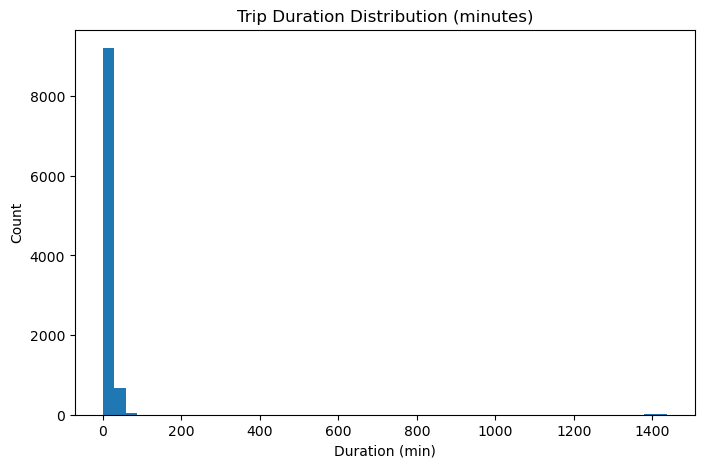

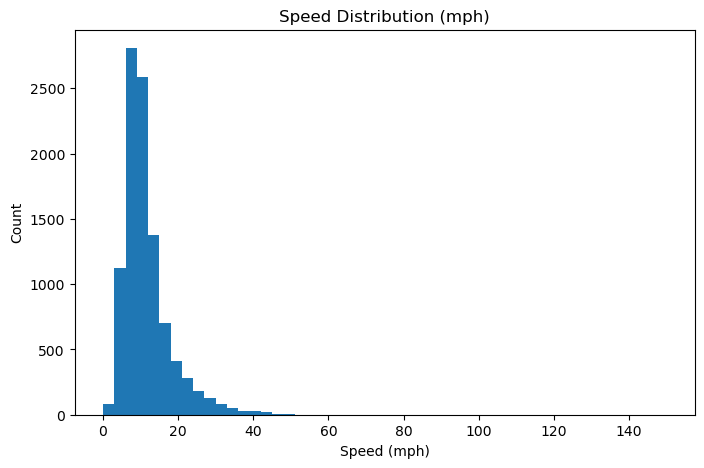

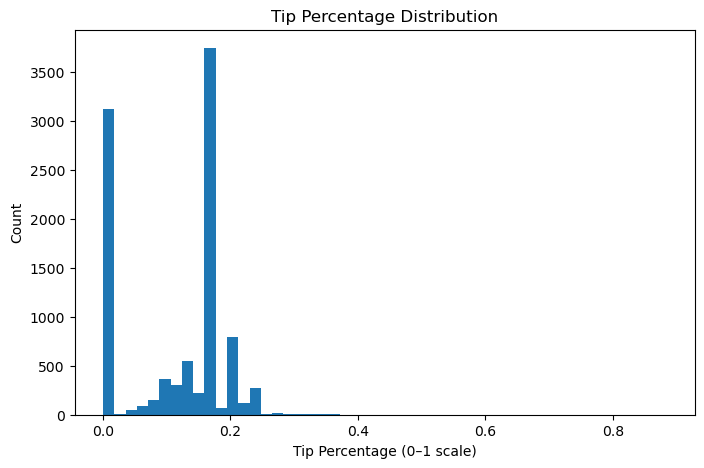

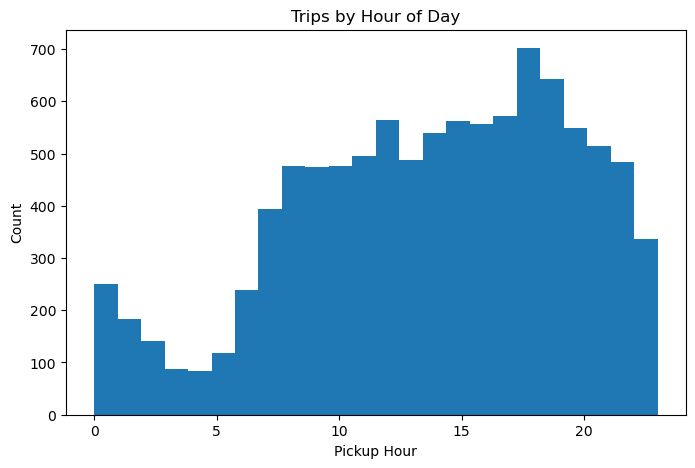

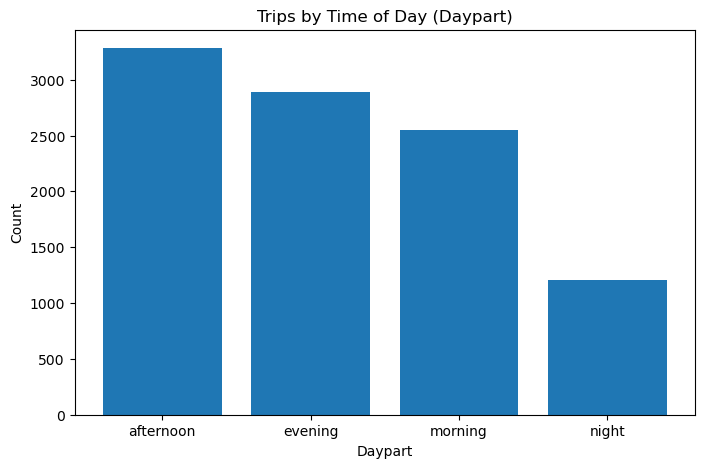

EDA complete.


In [11]:
# --- EDA on gold.taxi_trip_features ---

import matplotlib.pyplot as plt

# Load the table
df = con.sql("SELECT * FROM gold.taxi_trip_features").df()

print("Rows:", len(df))
print(df.head())

# -------- 1. Trip Duration Distribution --------
plt.figure(figsize=(8,5))
plt.hist(df["duration_min"].dropna(), bins=50)
plt.title("Trip Duration Distribution (minutes)")
plt.xlabel("Duration (min)")
plt.ylabel("Count")
plt.show()

# -------- 2. Speed Distribution --------
plt.figure(figsize=(8,5))
plt.hist(df["speed_mph"].dropna(), bins=50)
plt.title("Speed Distribution (mph)")
plt.xlabel("Speed (mph)")
plt.ylabel("Count")
plt.show()

# -------- 3. Tip Percentage Distribution --------
plt.figure(figsize=(8,5))
plt.hist(df["tip_pct"].dropna(), bins=50)
plt.title("Tip Percentage Distribution")
plt.xlabel("Tip Percentage (0–1 scale)")
plt.ylabel("Count")
plt.show()

# -------- 4. Trips by Hour of Day --------
plt.figure(figsize=(8,5))
plt.hist(df["pickup_hour"].dropna(), bins=24)
plt.title("Trips by Hour of Day")
plt.xlabel("Pickup Hour")
plt.ylabel("Count")
plt.show()

# -------- 5. Daypart Breakdown --------
daypart_counts = df["pickup_daypart"].value_counts()

plt.figure(figsize=(8,5))
plt.bar(daypart_counts.index, daypart_counts.values)
plt.title("Trips by Time of Day (Daypart)")
plt.xlabel("Daypart")
plt.ylabel("Count")
plt.show()

print("EDA complete.")


<Figure size 1000x500 with 0 Axes>

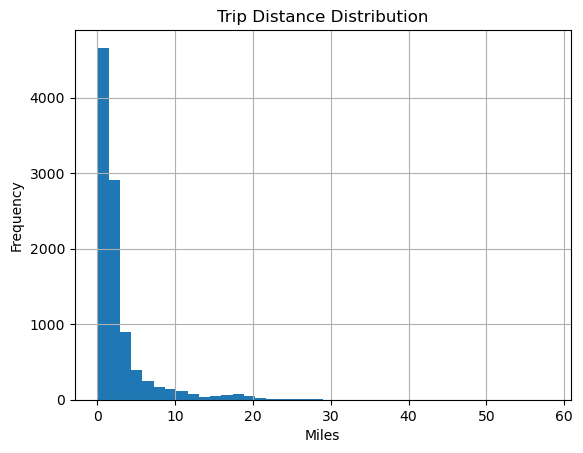

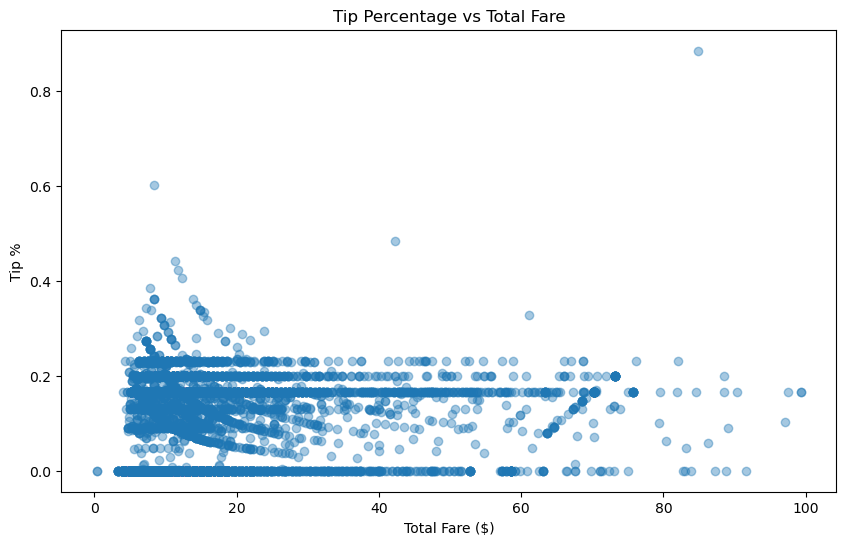

Plots generated successfully!


In [12]:
import matplotlib.pyplot as plt

# -------------------------------
# 1) Distribution of Trip Distance
# -------------------------------
plt.figure(figsize=(10,5))
con.sql("SELECT trip_distance FROM gold.taxi_trip_features").df().hist(bins=40)
plt.title("Trip Distance Distribution")
plt.xlabel("Miles")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# 2) Tip % vs Total Fare (scatter)
# -------------------------------
df_plot = con.sql("""
    SELECT tip_pct, total_amount
    FROM gold.taxi_trip_features
    WHERE tip_pct IS NOT NULL AND total_amount < 100
""").df()

plt.figure(figsize=(10,6))
plt.scatter(df_plot['total_amount'], df_plot['tip_pct'], alpha=0.4)
plt.title("Tip Percentage vs Total Fare")
plt.xlabel("Total Fare ($)")
plt.ylabel("Tip %")
plt.show()

print("Plots generated successfully!")
